# Palladium Price Prediction Using Python & Machine Learning

In [1]:
# Source "https://medium.com/@randerson112358/stock-price-prediction-using-python-machine-learning-e82a039ac2bb"

In [3]:
# Import bibliotek
import math
import pandas_datareader as web
import numpy as np
import os
import pandas as pd
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

C:\Users\Mateusz\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [4]:
os.chdir(r"C:\Users\Mateusz\Desktop\WSBProjekt\data")

In [5]:
# Stworzenie połączenia z bazą danych i pobranie indexu palladu
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

df = pd.read_sql_query("SELECT \"Index\",Date FROM Palladium", conn)
# Ustawienie indexu jako daty
df.set_index(df['Date'], inplace=True)

In [ ]:
# Wizualizacja za pomocą matplotlib.pyplot
plt.figure(figsize=(16,8))
plt.title('Palladium Price History')
plt.plot(df['Index'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)

# Utwórz nową ramkę danych tylko z kolumną Indeks
# Skonweruj do numpy, pobierz liczbę wierszy, na których ma być trenowany model
data = df.filter(['Index'])
dataset = data.values
training_data_len = math.ceil( len(dataset) *.7)

In [16]:
# Skalowanie wszystkich danych do wartości od 0 do 1 i utworzenia zbioru danych
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:training_data_len  , : ]

# Podzielenie danych na zestawy x_train i y_train
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
# Przekonwertowanie x_train and y_train do tablic numpy
x_train, y_train = np.array(x_train), np.array(y_train)    
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))  

In [17]:
# Zbudowanie modelu sieci LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2013/2013 [==============================] - 196s 97ms/step - loss: 2.8437e-04


In [18]:
# Ponownie podobne kroki dla test data

test_data = scaled_data[training_data_len - 60: , : ]

x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [26]:
# Uzyskanie modeli przewidywanych wartości cen
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

# Kalkulacja wartości RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

# Stworzenie zbioru danych do wykresu
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\Mateusz\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


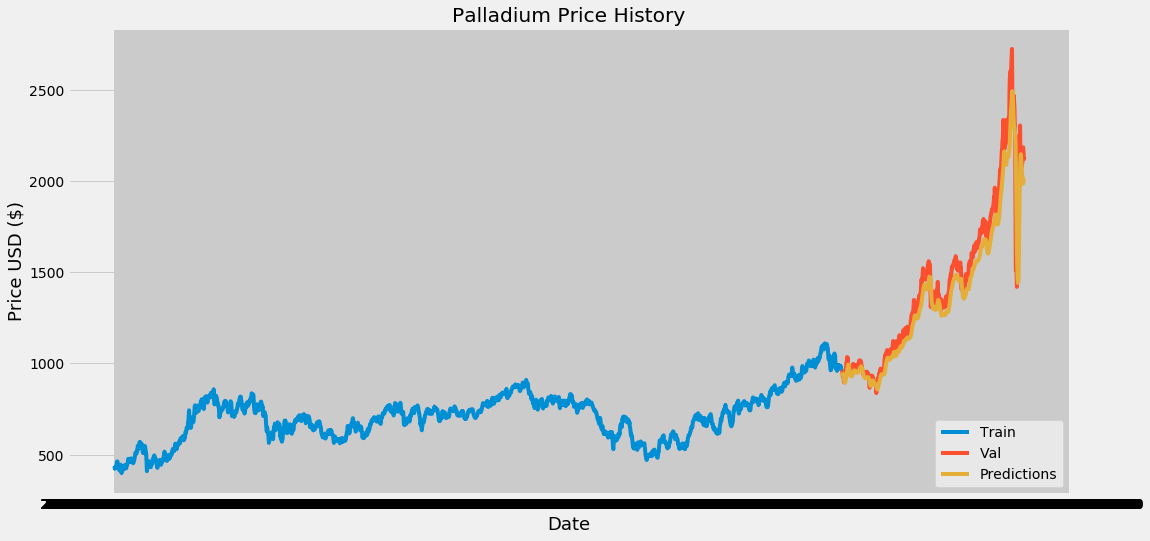

In [20]:
# Wizualizacja
plt.figure(figsize=(16,8))
plt.title('Palladium Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(train['Index'])
plt.plot(valid[['Index', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()